# [E-09] X-ray 이미지를 사용한 폐렴진단 (세번째 테스트 버전)

## Step 1. 실험환경 Set-up

In [67]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, Callback

import warnings 
warnings.filterwarnings(action='ignore')

In [203]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [150, 150]
BATCH_SIZE = 16
EPOCHS = 20
nb_train_samples = 5217
nb_validation_samples = 17

## Step 2. 데이터 준비하기

In [204]:
# 데이터 경로 변수 저장
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')


train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/train/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/val/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/test/*/*'))

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

train_data_dir = str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/train')
validation_data_dir = str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/val')
test_data_dir = str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/test')

In [205]:
# 데이터 개수 확인
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [206]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print('정상 이미지 개수: {0} \n폐렴 이미지 개수: {1}'.format(COUNT_NORMAL, COUNT_PNEUMONIA))

정상 이미지 개수: 1341 
폐렴 이미지 개수: 3875


In [207]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('train 이미지 개수: {0} \nval 이미지 개수: {1}'.format(TRAIN_IMG_COUNT, VAL_IMG_COUNT))

train 이미지 개수: 5216 
val 이미지 개수: 16


In [208]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/train/*'))])
print(CLASS_NAMES) # ['PNEUMONIA' 'NORMAL']

['NORMAL' 'PNEUMONIA']


In [209]:
# 라벨을 리턴하는 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    if parts[-2] == "PNEUMONIA" :
        return 1
    else:
        return 0

# 이미지 형식을 재지정 해주는 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

# 파일의 이미지와 라벨을 리턴하는 함수
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [210]:
# train, val dataset 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [211]:
# 이미지와 라벨이 잘 처리 되었는 지 확인
for image, label in train_ds.take(1): # take(1) 하나의 데이터만 가져오기
    print("Image shape: ", image.numpy().shape) # (180, 180, 3)
    print("Label: ", label.numpy()) # True

Image shape:  (150, 150, 3)
Label:  0


In [212]:
# testset 생성, 똑같이 처리
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

## 여기서 부터는 ImageDataGenerator 사용을 위한 세팅

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = str(ROOT_PATH + '/chest_xray/train')
validation_data_dir = str(ROOT_PATH + '/chest_xray/val')
test_data_dir = str(ROOT_PATH + '/chest_xray/test')

In [ ]:
img_width, img_height = 150, 150
epochs = 20
batch_size = 16

In [166]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Step 4. CNN 모델링

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

### 모델 Type1

In [187]:
# 모델 Type1

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
# 데이터 imbalance 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

### 모델 Type2

In [245]:
# 모델 Type2

# Conv Layer
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


# Dense Layer
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [246]:
# 데이터 imbalance 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


## 기본모델 훈련 1
- MODEL: TYPE1
- optimizer = 'adam'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

In [247]:
# 훈련 종료 call back 함수

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [143]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [144]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=val_ds,
        validation_steps=nb_validation_samples // batch_size,
        class_weight=class_weight,
        callbacks = [callbacks])

Epoch 1/20
326/326 [==============================] - 53s 117ms/step - loss: 0.3496 - accuracy: 0.8746 - precision: 0.9797 - recall: 0.8488 - val_loss: 0.5784 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 2/20
326/326 [==============================] - 37s 113ms/step - loss: 0.2352 - accuracy: 0.9371 - precision: 0.9821 - recall: 0.9324 - val_loss: 0.5678 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/20
326/326 [==============================] - 37s 115ms/step - loss: 0.1544 - accuracy: 0.9565 - precision: 0.9867 - recall: 0.9543 - val_loss: 0.6814 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 4/20
326/326 [==============================] - 38s 116ms/step - loss: 0.1536 - accuracy: 0.9544 - precision: 0.9861 - recall: 0.9520 - val_loss: 0.7557 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/20
326/326 [==============================] - 37s 115ms/step - loss: 0.1622 - accura

In [148]:
# Save model`s weights

model.save_weights(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/basic_model_1.h5'))

## 기본모델 훈련 2 (optimizer 변경)
- MODEL: TYPE1
- optimizer = 'rmsprop'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

In [ ]:
# 훈련 종료 call back 함수

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [147]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop', # 'adam'
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [149]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=val_ds,
        validation_steps=nb_validation_samples // batch_size,
        class_weight=class_weight,
        callbacks = [callbacks])

Epoch 1/20
326/326 [==============================] - 54s 118ms/step - loss: 0.0700 - accuracy: 0.9812 - precision: 0.9935 - recall: 0.9812 - val_loss: 0.5542 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/20
326/326 [==============================] - 37s 114ms/step - loss: 0.0733 - accuracy: 0.9804 - precision: 0.9896 - recall: 0.9840 - val_loss: 0.2721 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/20
326/326 [==============================] - 38s 115ms/step - loss: 0.0791 - accuracy: 0.9814 - precision: 0.9909 - recall: 0.9840 - val_loss: 0.6442 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/20
326/326 [==============================] - 38s 115ms/step - loss: 0.0781 - accuracy: 0.9816 - precision: 0.9912 - recall: 0.9840 - val_loss: 0.6642 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/20
326/326 [==============================] - 37s 115ms/step - loss: 0.0693 - accura

In [150]:
# Save model`s weights

model.save_weights(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/basic_model_2.h5'))

## augment 모델 훈련 1
- MODEL: TYPE1
- optimizer = 'adam'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

In [213]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

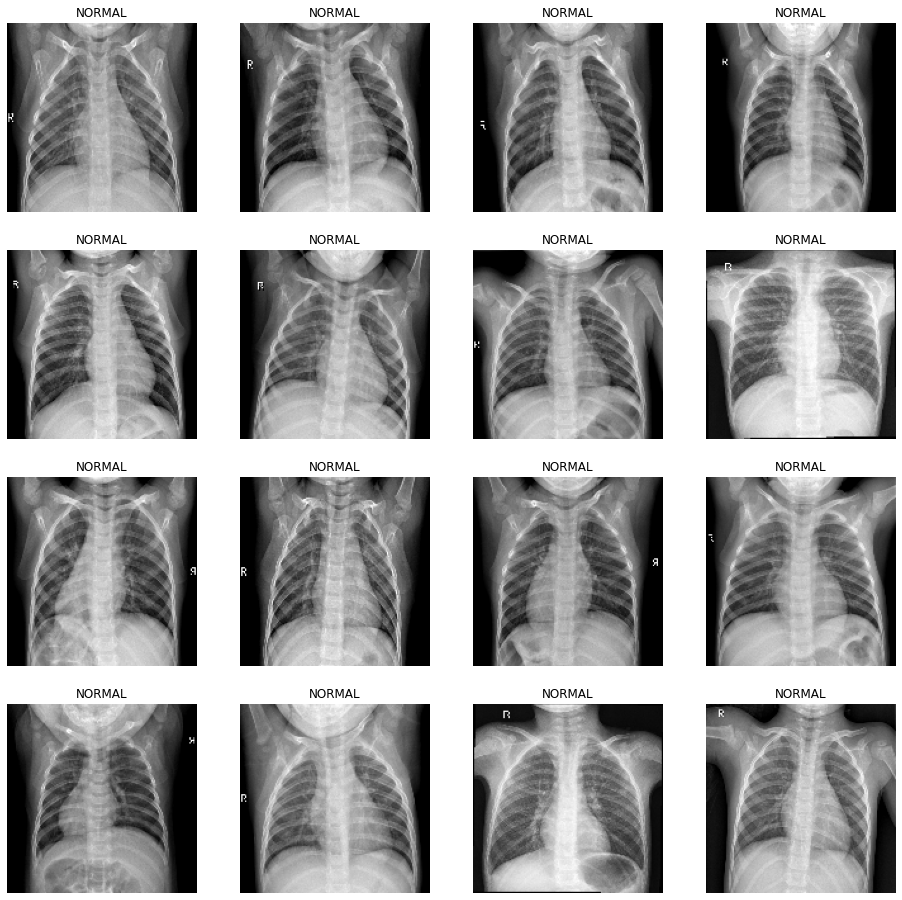

In [215]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,16))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [216]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam', # 'rmsprop'
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [217]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = [callbacks])

Epoch 1/20
326/326 [==============================] - 52s 117ms/step - loss: 0.0439 - accuracy: 0.9841 - precision: 0.9935 - recall: 0.9850 - val_loss: 0.7202 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 2/20
326/326 [==============================] - 37s 115ms/step - loss: 0.0660 - accuracy: 0.9808 - precision: 0.9924 - recall: 0.9817 - val_loss: 0.8134 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/20
326/326 [==============================] - 37s 114ms/step - loss: 0.0419 - accuracy: 0.9837 - precision: 0.9956 - recall: 0.9825 - val_loss: 2.1956 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 4/20
326/326 [==============================] - 37s 114ms/step - loss: 0.0816 - accuracy: 0.9743 - precision: 0.9898 - recall: 0.9755 - val_loss: 0.2553 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 5/20
326/326 [==============================] - 36s 110ms/step - loss: 0.0407 - accura

In [219]:
# Save model`s weights

model.save_weights(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/agment_model_1.h5'))

## augment 모델 훈련 2
- MODEL: TYPE1
- optimizer = 'rmsprop
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

In [225]:
# 훈련 종료 call back 함수 조건변경

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.81):
            print("\nReached 81% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [223]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop', # 'adam'
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [226]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = [callbacks])

Epoch 1/20
326/326 [==============================] - 53s 118ms/step - loss: 0.0347 - accuracy: 0.9933 - precision: 0.9961 - recall: 0.9948 - val_loss: 14.1946 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 2/20
326/326 [==============================] - 38s 116ms/step - loss: 0.0984 - accuracy: 0.9918 - precision: 0.9938 - recall: 0.9951 - val_loss: 1.8344 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/20
326/326 [==============================] - 38s 116ms/step - loss: 0.0325 - accuracy: 0.9927 - precision: 0.9961 - recall: 0.9941 - val_loss: 2.4205 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000

Reached 81% accuracy so cancelling training!


In [227]:
# Save model`s weights

model.save_weights(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/agment_model_2.h5'))

## ImageDataGenerator 모델 훈련 1
- MODEL: TYPE1
- optimizer = 'adam'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

In [232]:
# 훈련 종료 call back 함수 조건변경

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [233]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam', # 'rmsprop'
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [234]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        class_weight=class_weight,
        callbacks = [callbacks])

Epoch 1/20
326/326 [==============================] - 74s 226ms/step - loss: 0.3174 - accuracy: 0.9013 - precision: 0.9485 - recall: 0.9169 - val_loss: 2.0426 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/20
326/326 [==============================] - 73s 223ms/step - loss: 0.2483 - accuracy: 0.9109 - precision: 0.9618 - recall: 0.9164 - val_loss: 0.3974 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/20
326/326 [==============================] - 73s 224ms/step - loss: 0.2233 - accuracy: 0.9212 - precision: 0.9674 - recall: 0.9252 - val_loss: 0.4813 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/20
326/326 [==============================] - 73s 223ms/step - loss: 0.2258 - accuracy: 0.9183 - precision: 0.9657 - recall: 0.9228 - val_loss: 0.5636 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/20
326/326 [==============================] - 73s 225ms/step - loss: 0.1851 - accura

In [235]:
# Save model`s weights
    
model.save_weights(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/ImageDataGenerator_model_1.h5'))

## ImageDataGenerator 모델 훈련 2 (optimizer 변경)
- MODEL: TYPE1
- optimizer = 'rmsprop'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

In [239]:
# 훈련 종료 call back 함수 조건변경

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [240]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop', # 'adam'
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [241]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        class_weight=class_weight,
        callbacks = [callbacks])

Epoch 1/20
326/326 [==============================] - 74s 224ms/step - loss: 0.1396 - accuracy: 0.9532 - precision: 0.9804 - recall: 0.9561 - val_loss: 0.4746 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/20
326/326 [==============================] - 73s 223ms/step - loss: 0.1410 - accuracy: 0.9571 - precision: 0.9810 - recall: 0.9608 - val_loss: 0.6712 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/20
326/326 [==============================] - 72s 222ms/step - loss: 0.1516 - accuracy: 0.9555 - precision: 0.9828 - recall: 0.9569 - val_loss: 0.6285 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/20
326/326 [==============================] - 72s 222ms/step - loss: 0.1588 - accuracy: 0.9482 - precision: 0.9790 - recall: 0.9507 - val_loss: 2.5162 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/20
326/326 [==============================] - 72s 222ms/step - loss: 0.1827 - accura

In [242]:
# Save model`s weights

model.save_weights(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/ImageDataGenerator_model_2.h5'))

## ImageDataGenerator 모델2 훈련 (모델 변경)
- MODEL: TYPE2
- optimizer = 'adam'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

In [250]:
# 훈련 종료 call back 함수 조건변경

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [251]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam', # 'rmsprop'
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [252]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        class_weight=class_weight,
        callbacks = [callbacks])

Epoch 1/20
326/326 [==============================] - 74s 226ms/step - loss: 0.1911 - accuracy: 0.9433 - precision: 0.9768 - recall: 0.9461 - val_loss: 0.3795 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/20
326/326 [==============================] - 74s 226ms/step - loss: 0.1598 - accuracy: 0.9486 - precision: 0.9798 - recall: 0.9505 - val_loss: 0.4351 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/20
326/326 [==============================] - 73s 223ms/step - loss: 0.1536 - accuracy: 0.9525 - precision: 0.9812 - recall: 0.9543 - val_loss: 0.3645 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/20
326/326 [==============================] - 73s 224ms/step - loss: 0.1266 - accuracy: 0.9580 - precision: 0.9823 - recall: 0.9608 - val_loss: 1.1143 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/20
326/326 [==============================] - 73s 223ms/step - loss: 0.1302 - accura

In [253]:
# Save model`s weights

model.save_weights(str(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/ImageDataGenerator_model_3.h5'))

# 모델별 Summary

### 기본모델 1 평가
- MODEL: TYPE1
- optimizer = 'adam'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

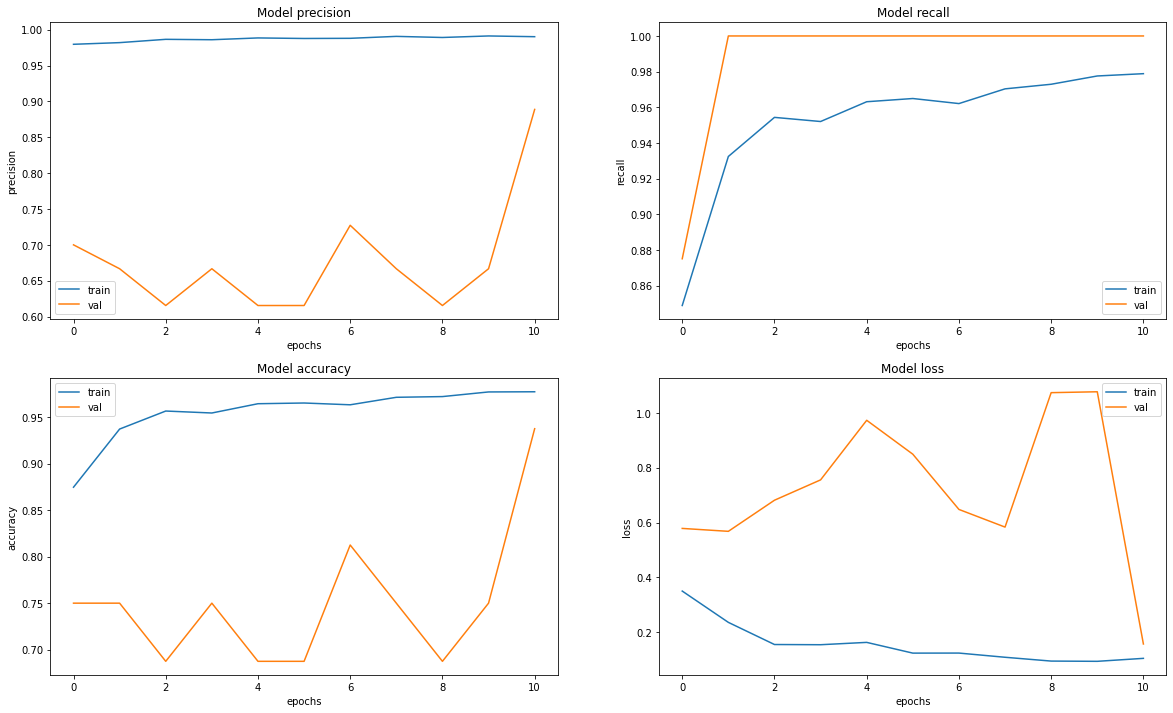

In [145]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [146]:
# 모델 평가

scores = model.evaluate(test_ds)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

39/39 [==============================] - 4s 104ms/step - loss: 1.6082 - accuracy: 0.7452 - precision: 0.7112 - recall: 0.9974

accuracy: 74.52%


### 기본모델 2 평가
- MODEL: TYPE1
- optimizer = 'rmsprop'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

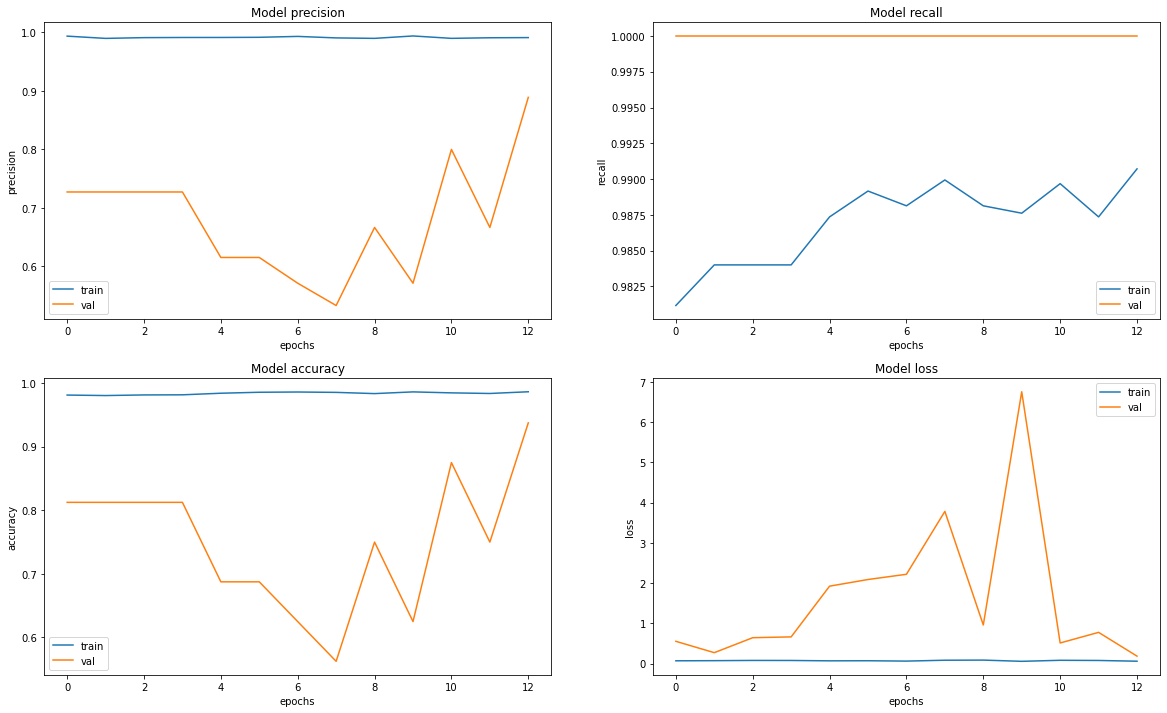

In [151]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [152]:
# 모델 평가

scores = model.evaluate(test_ds)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

39/39 [==============================] - 4s 110ms/step - loss: 1.4383 - accuracy: 0.7580 - precision: 0.7268 - recall: 0.9821

accuracy: 75.80%


### agment 1 모델 평가
- MODEL: TYPE1
- optimizer = 'adam'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

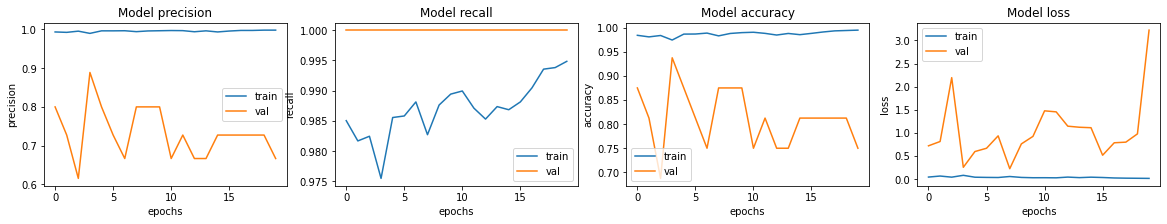

In [220]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [221]:
# evaluate the model

scores = model.evaluate(test_ds)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

39/39 [==============================] - 4s 103ms/step - loss: 5.6971 - accuracy: 0.6715 - precision: 0.6555 - recall: 1.0000

accuracy: 67.15%


### agment 2 모델 평가
- MODEL: TYPE1
- optimizer = 'rmsprop'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

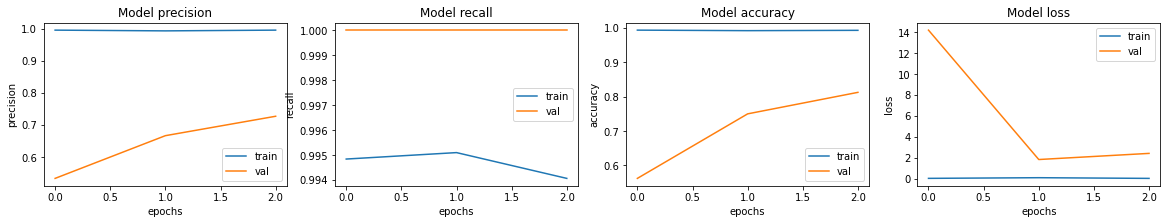

In [228]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [229]:
# evaluate the model

scores = model.evaluate(test_ds)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

39/39 [==============================] - 4s 94ms/step - loss: 8.3252 - accuracy: 0.6747 - precision: 0.6577 - recall: 1.0000

accuracy: 67.47%


### ImageDataGenerator 1 모델 평가
- MODEL: TYPE1
- optimizer = 'adam'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

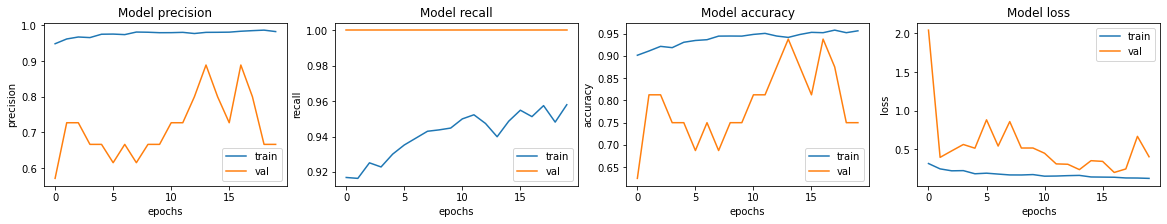

In [236]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [237]:
# evaluate the model
scores = model.evaluate(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

39/39 [==============================] - 5s 134ms/step - loss: 0.3490 - accuracy: 0.9103 - precision: 0.8920 - recall: 0.9744

accuracy: 91.03%


### ImageDataGenerator 2 모델 평가
- MODEL: TYPE1
- optimizer = 'rmsprop'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

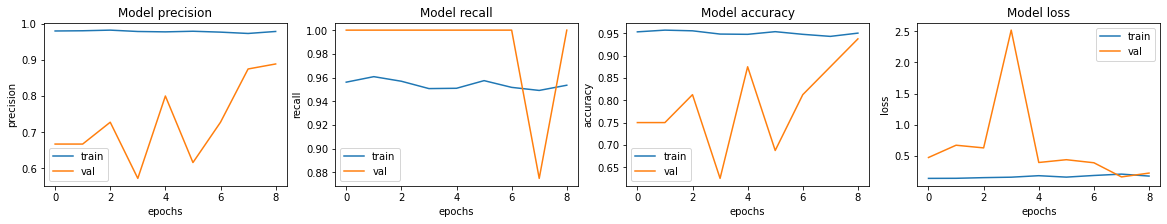

In [243]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [244]:
# evaluate the model
scores = model.evaluate(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

39/39 [==============================] - 5s 137ms/step - loss: 0.4422 - accuracy: 0.8910 - precision: 0.9025 - recall: 0.9256

accuracy: 89.10%


### ImageDataGenerator 3 모델 평가
- MODEL: TYPE2
- optimizer = 'adam'
- IMAGE_SIZE = [150, 150]
- BATCH_SIZE = 16
- EPOCHS = 20

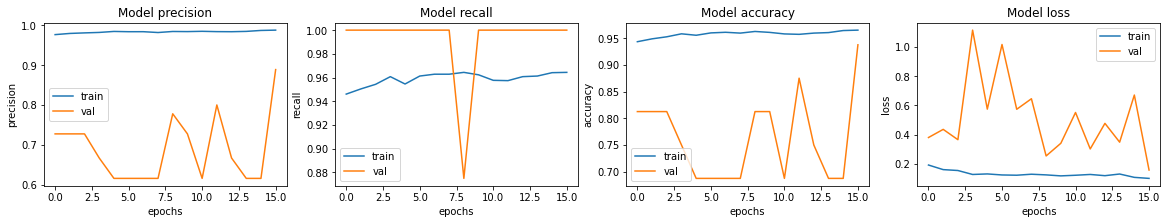

In [254]:
# 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [255]:
# evaluate the model
scores = model.evaluate(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

39/39 [==============================] - 5s 132ms/step - loss: 0.3597 - accuracy: 0.9279 - precision: 0.9137 - recall: 0.9769

accuracy: 92.79%


## 회고

- 첫 테스트, 수정한 것이라고는 train data와 varidation data를 합친후 8:2로 재 배분한 것외에는 아무것도 없었으나 accuracy가 98% 가량 나와서 일단 업로드 완료 한 상태였음. 다른 조건으로 몇번을 테스트 해도 aaccuracy가 98% 이상 나오는 상황. 


- 이 후 조원들과 관련 내용에 대한 논의를 하던 중 조원들은 기본 상태에서 75%가량 나오며 80%를 넘기기가 어렵다는 이야기를 들음  


- 무엇인가 이상함을 감지하고 나의 코드를 조원들이 분석하던 중 엄청난 실수를 발견함, test data를 생성하기 위한 폴더 지정에 train data 폴더를 지정한 상황을 확인함, 그러니 무엇을 해도 정확도가 98% 가 나오는 것이지 ㅜㅠ


- 이후 멘붕이 와서 폴더를 제대로 변경하고 트레이닝을 시키고 검증을 한 결과 75%의 정확도가 나오는 것을 확인함.  


- 기왕 이렇게 된거 제대로 다시한번 해보자는 마음가짐으로 처음부터 다시 테스트 계획을 짬  


- 이번에는 test와 validation 데이터 셋을 합친 후 8:2로 배분하지 않고 있는 그대로 진행하기로 하였음  


- 또한 모델을 만들기 위한 optimizer를 'adam'과 'RMSprop'의 두 가지 종류를 사용하기로 함 각각의 장단점에 대한 부분은 저 아래 북마크에서 확인 할 수 있다. 


- 모델 또한 두가지 타입을 설정하여 테스트를 진행하였다.  


- 또한 argumentation도 LMS에서 나왔던 방법과 ImageDataGenerator의 두가지 방법을 사용하여 진행하였다.  


- 그 결과 Model type1 에서는 다음과 같은 수준의 정확도를 얻을 수 있었다.  
(1) ImageDataGenerator 1: 91.03%  
(2) ImageDataGenerator 2: 89.10%  
(3) 기본모델 2: 75.80%  
(4) 기본모델 1: 74.52%  
(5) agment 2 모델: 67.47%  
(6) agment 1 모델: 67.15% 

왜 LMS 에서 알려준 arugumentation 방식은 정확도가 저렇게 떨어지는 것일까? 일단 궁금하긴 했지만 해당 부분을 확인하는 것은 다음으로 미루기로 했다. 제출마감 시간이 얼마 남지 않은 관계로 ㅜㅠ


- Model Type2 에서는 가장 높게 나온 모델을 기준으로 테스트를 진행하였고 다음과 같이 나왔다.  
(1) ImageDataGenerator 1: 92.79%


### 결론적으로 Model Type2 기반의 ImageDataGenerator 1가  
### 92.79%의 정확도를 보였다.  

<br>
<br>
<br>

- 의료영상 분야에서 어떤 식으로 활용되는지 확인 할 수 있는 시간이었다.

- 텐서플로에 대해서 완전하게 이해되지 않는 부분이 몇가지 있어서 남는 시간은 CNN 모델에 대한 이해와 텐서플로를 이해하는데 투자 하려고 한다.

- 본 프로젝트의 프로세스는 이해 됐으나 세부적인 코드의 구성과 작동방법에 대해서 아직 이해 되지 않는 부분이 존재한다. 역시 추가적으로 공부해서 이해하려고 한다.

- 현재 1차 제출한 상태고 위에서 언급 한 것들을 추가적으로 공부한뒤 하이퍼 파라메터 또는 모델들을 변형하여 정확도를 좀더 높여 볼계획이다.  

- 지금 변경해서 실험하려고 예상하고 있는 것들은 Convolution Layer의 filter의 크기, 배치사이즈, 이미지의 해상도 정도이다.  

https://onevision.tistory.com/entry/Optimizer-%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%ED%8A%B9%EC%84%B1-Momentum-RMSProp-Adam